In [5]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import hnn_core
from hnn_core import (MPIBackend, jones_2009_model, simulate_dipole,
                      read_dipole, read_network_configuration)
from hnn_core.viz import plot_dipole
from scipy.stats import norm
import pickle

In [7]:
net = read_network_configuration('../data/opt_baseline_config_correlation_best.json')
dpl = simulate_dipole(net, tstop=250, n_trials=1)

Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Loading custom mechanism files from /users/ntolley/.conda/envs/jaxley2/lib/python3.11/site-packages/hnn_core/mod/x86_64/libnrnmech.so
Building the NEURON model
[Done]
Trial 1: 0.03 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Trial 1: 60.0 ms...
Trial 1: 70.0 ms...
Trial 1: 80.0 ms...
Trial 1: 90.0 ms...
Trial 1: 100.0 ms...
Trial 1: 110.0 ms...
Trial 1: 120.0 ms...
Trial 1: 130.0 ms...
Trial 1: 140.0 ms...
Trial 1: 150.0 ms...
Trial 1: 160.0 ms...
Trial 1: 170.0 ms...
Trial 1: 180.0 ms...
Trial 1: 190.0 ms...
Trial 1: 200.0 ms...
Trial 1: 210.0 ms...
Trial 1: 220.0 ms...
Trial 1: 230.0 ms...
Trial 1: 240.0 ms...


In [8]:
labelsize = 13
ticksize = 10

baseline_sim = dpl[0].copy().smooth(40).scale(1000)
baseline_sim_data = baseline_sim.data['agg']
sim_times = dpl[0].times

# Load experimental biomarker
dipole_experimental = read_dipole('../data/L_Contra.txt')
times = dipole_experimental.times

# Copy and store data in numpy array
dipole_synthetic = dipole_experimental.copy()
dpl_data = dipole_synthetic.data['agg']

# Create gaussian window
biomarker_scale = 0.3
gauss = norm.pdf(times, loc=20, scale=90)
gauss = (gauss / np.max(gauss)) * (biomarker_scale - 1)
gauss += 1  # Offset by 1 so that multiplying at tails has no effect

# Scale and re-assign data to Dipole object
dpl_data = dpl_data * gauss
dipole_synthetic.data['agg'] = dpl_data





(array([-50., -40., -30., -20., -10.,   0.,  10.,  20.]),
 [Text(0, -50.0, '−50'),
  Text(0, -40.0, '−40'),
  Text(0, -30.0, '−30'),
  Text(0, -20.0, '−20'),
  Text(0, -10.0, '−10'),
  Text(0, 0.0, '0'),
  Text(0, 10.0, '10'),
  Text(0, 20.0, '20')])

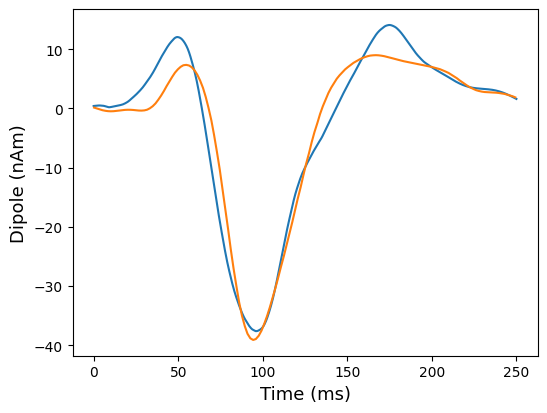

In [9]:
plt.figure(figsize=(6,4.5))
plt.plot(sim_times, baseline_sim_data, label='Optimized')
plt.plot(times, dipole_experimental.data['agg'], label='Baseline')
plt.xlabel('Time (ms)', fontsize=labelsize)
plt.ylabel('Dipole (nAm)', fontsize=labelsize)
plt.xticks(fontsize=ticksize)
plt.yticks(fontsize=ticksize)

In [10]:
# dipole_synthetic.write('../data/post-treatment_erp.txt')
# dpl[0].write('../data/optimized_baseline.txt')

In [14]:
# Issue, need to have set_params method to load pickle file
def set_params(net, params):

    # Add proximal drives
    weights_ampa_p1 = {"L2_basket": 0.08831 * (10 ** params['evprox1_ampa_L2_basket']),
                       "L2_pyramidal": 0.01525 * (10 ** params['evprox1_ampa_L2_pyramidal']),
                       "L5_basket": 0.19934 * (10 ** params['evprox1_ampa_L5_basket']),
                       "L5_pyramidal": 0.00865 * (10 ** params['evprox1_ampa_L5_pyramidal']),}
    synaptic_delays_p = {"L2_basket": 0.1, "L2_pyramidal": 0.1,
                            "L5_basket": 1.0,"L5_pyramidal": 1.0,}

    # Proximal 1
    net.add_evoked_drive('evprox1',
                         mu=params['evprox1_mu'],
                         sigma=params['evprox1_sigma'],
                         numspikes=1,
                         location='proximal',
                         weights_ampa=weights_ampa_p1,
                         synaptic_delays=synaptic_delays_p)


    # Add distal drive
    weights_ampa_d1 = {"L2_basket": 0.006562 * (10 ** params['evdist1_ampa_L2_basket']),
                       "L2_pyramidal": 7e-6 * (10 ** params['evdist1_ampa_L2_pyramidal']),
                       "L5_pyramidal": 0.142300 * (10 ** params['evdist1_ampa_L5_pyramidal']),}
    weights_nmda_d1 = {"L2_basket": 0.019482 * (10 ** params['evdist1_nmda_L2_basket']),
                        "L2_pyramidal": 0.004317 * (10 ** params['evdist1_nmda_L2_pyramidal']),
                        "L5_pyramidal": 0.080074 * (10 ** params['evdist1_nmda_L5_pyramidal']),}
    synaptic_delays_d1 = {"L2_basket": 0.1, "L2_pyramidal": 0.1, "L5_pyramidal": 0.1}

    # Distal
    net.add_evoked_drive('evdist1',
                         mu=params['evdist1_mu'],
                         sigma=params['evdist1_sigma'],
                         numspikes=1,
                         location='distal',
                         weights_ampa=weights_ampa_d1,
                         weights_nmda=weights_nmda_d1,
                         synaptic_delays=synaptic_delays_d1)

    # Proximal 2
    weights_ampa_p2 = {'L2_basket': 0.000003 * (10 ** params['evprox2_ampa_L2_basket']),
                       'L2_pyramidal': 1.438840 * (10 ** params['evprox2_ampa_L2_pyramidal']),
                       'L5_basket': 0.008958 * (10 ** params['evprox2_ampa_L5_basket']),
                       'L5_pyramidal': 0.684013 * (10 ** params['evprox2_ampa_L5_pyramidal'])}
    net.add_evoked_drive('evprox2',
                         mu=params['evprox2_mu'],
                         sigma=params['evprox2_sigma'],
                         numspikes=1,
                         location='proximal',
                         weights_ampa=weights_ampa_p2,
                         synaptic_delays=synaptic_delays_p)


def _corr_evoked(
    initial_net,
    initial_params,
    set_params,
    predicted_params,
    update_params,
    obj_values,
    tstop,
    obj_fun_kwargs,
):
    """The objective function for evoked responses.

    Parameters
    ----------
    initial_net : instance of Network
        The network object.
    initial_params : dict
        Keys are parameter names, values are initial parameters.
    set_params : func
        User-defined function that sets network drives and parameters.
    predicted_params : list
        Parameters selected by the optimizer.
    update_params : func
        Function to update params.
    tstop : float
        The simulated dipole's duration.
    target : instance of Dipole
        A dipole object with experimental data.
    n_trials : int
        Number of trials to simulate and average.

    Returns
    -------
    obj : float
        Normalized RMSE between recorded and simulated dipole.
    """

    params = update_params(initial_params, predicted_params)

    # simulate dpl with predicted params
    new_net = initial_net.copy()
    set_params(new_net, params)

    dpls = simulate_dipole(new_net, tstop=tstop, n_trials=obj_fun_kwargs["n_trials"], dt=obj_fun_kwargs['dt'])

    # smooth & scale
    if "scale_factor" in obj_fun_kwargs:
        [dpl.scale(obj_fun_kwargs["scale_factor"]) for dpl in dpls]
    if "smooth_window_len" in obj_fun_kwargs:
        [dpl.smooth(obj_fun_kwargs["smooth_window_len"]) for dpl in dpls]

    dpl = average_dipoles(dpls)
    obj = _rmse(dpl, obj_fun_kwargs["target"], tstop=tstop)
    obj_values.append(obj)

    print(f'RMSE: {obj:.2f}')

    return obj

In [15]:
with open('../data/opt_baseline_object_correlation_best.pkl', 'rb') as file:
    opt_run = pickle.load(file)

(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120.]),
 [Text(-20.0, 0, '−20'),
  Text(0.0, 0, '0'),
  Text(20.0, 0, '20'),
  Text(40.0, 0, '40'),
  Text(60.0, 0, '60'),
  Text(80.0, 0, '80'),
  Text(100.0, 0, '100'),
  Text(120.0, 0, '120')])

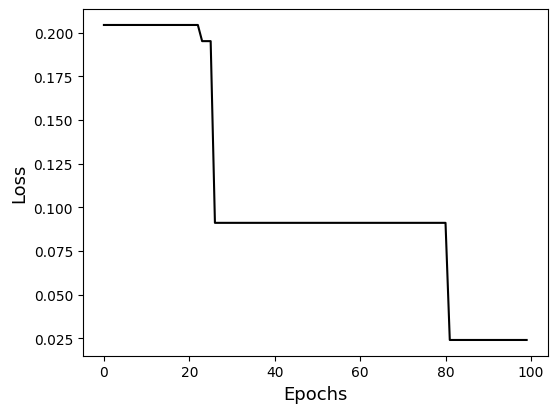

In [16]:
plt.figure(figsize=(6,4.5))
plt.plot(opt_run.obj_, color='k')
plt.xlabel('Epochs', fontsize=labelsize)
plt.ylabel('Loss', fontsize=labelsize)
plt.xticks(fontsize=ticksize)
plt.xticks(fontsize=ticksize)